# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [132]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax

In [133]:
print(jnp.ones(3).devices())

{cuda(id=0)}


In [134]:
seed = 120
globe_key = jrandom.PRNGKey(seed)
key = globe_key
globe_key, subkey = jrandom.split(globe_key)


def key_gen(key):
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey



In [135]:
# experiment settings
sample_size = 200
time_steps = 1
subkey = key_gen(globe_key)
target_dist = jrandom.multivariate_normal(subkey, jnp.zeros(2)+1  , jnp.eye(2)*3, (sample_size,))
del subkey
# target_dist_2 = jrandom.multivariate_normal(key, jnp.zeros(2) + 5, jnp.eye(2) * 0.8, (sample_size,))
# target_dist = jnp.concatenate([target_dist, target_dist_2], axis=0)
sample_size = jnp.shape(target_dist)[0]


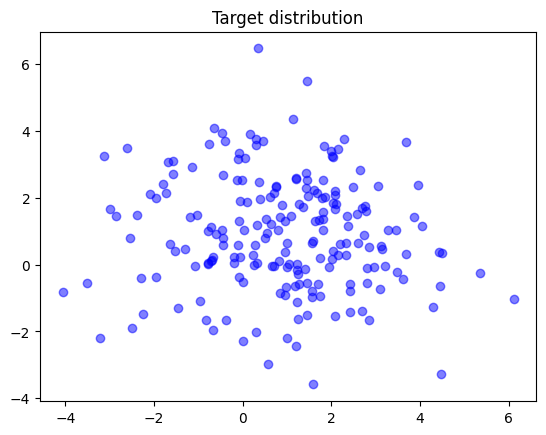

In [136]:
# plot the target distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', alpha=0.5)
ax.set_title('Target distribution')
plt.show()

noises shape:  (1, 200, 2)
corrupted samples shape:  (200, 2)
noise shape:  (1, 200, 2)


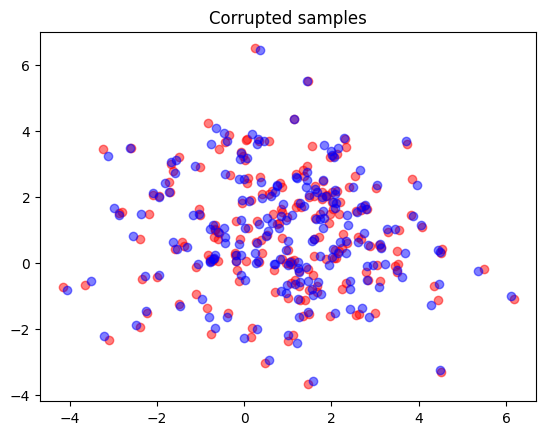

In [137]:
# define corrupted target distribution
noise_sigma = 0.1
def compute_noises(noise_shape, t, sigma, seed, sigma_type='constant'):
    noises = []
    current_noise = jnp.zeros(noise_shape)
    if sigma_type == 'constant':
        for i in range(t):
            seed += 1
            key = jrandom.PRNGKey(seed)
            current_noise = jrandom.multivariate_normal(key, jnp.zeros(2), jnp.eye(2)*(sigma**2), (sample_size,)) * sigma
            noises.append(current_noise)
        return jnp.array(noises)
    elif sigma_type == 'geometric':
        for i in range(t):
            seed += 1
            key = jrandom.PRNGKey(seed)
            current_noise = jrandom.multivariate_normal(key, jnp.zeros(2), jnp.eye(2) * (sigma[i]**2), (sample_size,))
            noises.append(current_noise)
    return jnp.array(noises)
geo_sigma = jnp.geomspace(0.1, 1, time_steps)

# noises = compute_noises(jnp.shape(target_dist), time_steps, geo_sigma, seed, 'geometric')

noises = compute_noises(jnp.shape(target_dist), time_steps, noise_sigma, seed, 'constant')
# noises = jnp.reshape(noises, (noises.shape[1], noises.shape[2]))
print("noises shape: ", jnp.shape(noises))
def add_noise(target_dist, noises):
    time_steps = jnp.shape(noises)[0]
    corrupted_target_dist = []
    corrupted_target_dist.append(target_dist)
    for i in range(time_steps):
        print(target_dist)
        target_dist += noises[i]
        print(target_dist)
        corrupted_target_dist.append(target_dist)
    corrupted_target_dist = jnp.array(corrupted_target_dist)
    return corrupted_target_dist

def add_noise_onestep(target_dist, sigma):
    
    def add_noise_fn(x, sigma, key):
        # print("x shape: ", jnp.shape(x))
        # print("sigma shape: ", jnp.shape(sigma))
        # print("jnp.zeros(2) shape: ", jnp.shape(jnp.zeros(2)))
        # noise = jrandom.multivariate_normal(key, jnp.zeros(2), jnp.eye(2) * (sigma**2))
        
        noise = jrandom.normal(key, x.shape) * sigma
        # print("noise shape: ", jnp.shape(noise))
        return noise + x
    sigma = jnp.expand_dims(sigma, axis=0)
    sigma = jnp.repeat(sigma, target_dist.shape[0], axis=0)
    sigma = jnp.reshape(sigma, (target_dist.shape[0], 1))
    # print("sigma shape: ", jnp.shape(sigma))
    # global globe_key
    
    subkey = key_gen(globe_key)
    keys = jrandom.split(subkey, target_dist.shape[0])
    
    del subkey
    
    keys = keys.reshape((target_dist.shape[0],-1))
    # print("keys shape: ", jnp.shape(keys))
    corrupted_target_dist = jax.vmap(add_noise_fn, in_axes=(0, 0, 0))(target_dist, sigma, keys)
    
    return corrupted_target_dist


corrupted_target_dist = add_noise_onestep(target_dist, noise_sigma)


# corrupted_target_dist = add_noise(target_dist, noises)
print("corrupted samples shape: ", jnp.shape(corrupted_target_dist))
print("noise shape: ", jnp.shape(noises))

cmap = plt.get_cmap('rainbow')
fig, ax = plt.subplots()

ax.scatter(corrupted_target_dist[:, 0], corrupted_target_dist[:, 1],c='r', alpha=0.5)
ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', alpha=0.5)
ax.set_title('Corrupted samples')
plt.show()



In [138]:
# # plot the gradient of function
# import matplotlib.pyplot as plt
# import numpy as np
# 
# colormap = plt.cm.get_cmap('rainbow')
# colormap_trace = plt.cm.get_cmap('hot')
# 
# fig, ax = plt.subplots()
# 
# for i in range(time_steps - 1):
#     previous = corrupted_target_dist[i]
#     current = corrupted_target_dist[i+1]
#     for j in range(sample_size):
#         ax.scatter(previous[j, 0], previous[j, 1], c= colormap(j/sample_size), alpha=0.5)
#         ax.scatter(current[j, 0], current[j, 1], c=colormap(j/sample_size), alpha=0.5)
#         ax.plot([previous[j, 0], current[j, 0]], [previous[j, 1], current[j, 1]], 'k-', alpha=0.2)
# 
# ax.set_title('Corrupted samples along time')
# plt.show()


In [139]:
# define the model
class NaiveMLP(nn.Module):
    @nn.compact
    def __call__(self, x , sigma):
        # extend the sigma to the same shape as x
        sigma = jnp.expand_dims(sigma, axis=0)


        sigma = nn.Dense(features=4)(sigma)
        sigma = nn.relu(sigma)
        
        sigma = nn.Dense(features=16)(sigma)
        sigma = nn.relu(sigma)
        sigma = jnp.expand_dims(sigma, axis=0)
        sigma = jnp.repeat(sigma, jnp.shape(x)[0], axis=0)        
        x = nn.Dense(features=16)(x) 
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x) 
        x = nn.relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.relu(x)
        inner_features = jnp.concatenate([x, sigma], axis=1)
        x = nn.Dense(features=16)(inner_features)
        x = nn.relu(x)
        x = nn.Dense(features=2)(x)
    
        return x
    
class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x

In [140]:
# dsm loss function for all time steps
# def dsm_loss_fn(pred_dist, corrupted_target_dist, sigma, t):
#     def dsm_loss(pred_dist, corrupted_target_dist, sigma, t):
#         loss = 0
#         for i in range(t):
#             term = pred_dist[i] + (corrupted_target_dist[i] - corrupted_target_dist[i])/sigma[i] **2
#             term = jnp.mean(term ** 2)
#             term = term * sigma[i] ** 2
#             loss += term
#         return loss
#     return jax.jit(dsm_loss)

from flax.training import train_state

# def init_train_state(key, model, corrupted_target_dist, geo_sigma) ->train_state.TrainState:
#     params = model.init(key, corrupted_target_dist[0], geo_sigma[0])
#     optimizer = optax.adam(learning_rate=1e-3)
#     return train_state.TrainState.create(
#         apply_fn=model.apply,
#         params=params,
#         tx=optimizer,
#     )


def init_train_state_onestep(key, model, x) ->train_state.TrainState:
    params = model.init(key, x)
    optimizer = optax.adam(learning_rate=5e-4)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )



    
    

In [141]:
# define the train epoch function
@jax.jit
def train_epoch(state: train_state.TrainState, target_dist: jnp.ndarray, corrupted_target_dist: jnp.ndarray, sigmas):    
    
    # def dsm_loss_fn(params):
    #     # define the loss of a single time step
    #     def one_step_dsm(x, x_noised, sigma):
    #         pred_score = jnp.mean(state.apply_fn(params, x, sigma), axis=0)
    #         print("pred_score: ", pred_score.shape)
    #         real_score = jnp.mean((x - x_noised)/ (sigma ** 2), axis=0)
    #         print("real_score: ", real_score.shape)
    #         return ((pred_score - real_score)**2) * sigma ** 2
    #     x_1 = corrupted_target_dist[:-1]
    #     x_2 = corrupted_target_dist[1:]
    #     all_time_result = jax.vmap(one_step_dsm)(x_1, x_2, sigmas[1:])
    #     return jnp.sum(all_time_result)
    # print("target_dist shape: ", jnp.shape(target_dist))
    # print("corrupted_target_dist shape: ", jnp.shape(corrupted_target_dist))
    # sample the target distribution
    global globe_key
    subkey = key_gen(globe_key)
    # target_dist = jrandom.multivariate_normal(subkey, jnp.zeros(2)  , jnp.eye(2) *0.25, (sample_size,))
    # target_dist = jrandom.multivariate_normal(subkey, jnp.zeros(2)  , jnp.eye(2)*0.25, (sample_size,))
    target_dist = jrandom.uniform(subkey, (sample_size, 2), minval=-5, maxval=5)
    del subkey
    corrupted_target_dist = add_noise_onestep(target_dist, noise_sigma)
    # print("key for corrupted target dist: ", globe_key)
    def one_step_dsm(params):
        def mse_score(x, x_noised, sigma):
            # print("x shape: ", jnp.shape(x))
            # print("x_noised shape: ", jnp.shape(x_noised))
            # print("sigma shape: ", jnp.shape(sigma))
            pred = state.apply_fn(params, x_noised)
            # print("pred shape: ", jnp.shape(pred))
            true = x_noised - x / (sigma ** 2)
            print("true shape: ", jnp.shape(true))
            return jnp.sum(jnp.linalg.norm(pred - true))/2
        
        sigma = jnp.array([noise_sigma])
        return jnp.mean(jax.vmap(mse_score, in_axes=(0,0,None))(target_dist, corrupted_target_dist, sigmas))
        # return mse_score(target_dist, corrupted_target_dist, sigmas)*0.5/target_dist.shape[0]
    loss_fn = one_step_dsm
    grad_fn = jax.value_and_grad(loss_fn)    
    loss, grad = grad_fn(state.params)
    state = state.apply_gradients(grads=grad)

    return state, loss

model = Onestep_score_MLP()


# state = init_train_state(params_rng, model, target_dist, jnp.array(noise_sigma))
state = init_train_state_onestep(key_gen(globe_key), model, target_dist[0])
for i in range(100000):
    state, loss = train_epoch(state, target_dist, corrupted_target_dist, jnp.array(noise_sigma))
    if i % 1000 == 0:
        print("loss: ", loss)

    


true shape:  (2,)
loss:  181.50136
loss:  114.34069
loss:  73.244194
loss:  44.558426
loss:  28.683617
loss:  27.851557
loss:  7.7631454
loss:  6.276702
loss:  6.0364304
loss:  5.824481
loss:  5.738712
loss:  5.7063184
loss:  5.653436
loss:  5.639327
loss:  5.608019
loss:  5.583379
loss:  5.578363
loss:  5.5492687
loss:  5.520278
loss:  5.551534
loss:  5.5530252
loss:  5.5171313
loss:  5.485498
loss:  5.480803
loss:  5.518093
loss:  5.478458
loss:  5.4750013
loss:  5.4578156
loss:  5.451937
loss:  5.461566
loss:  5.4300823
loss:  5.4392443
loss:  5.4534245
loss:  5.403408
loss:  5.398756
loss:  5.3739085
loss:  5.3427587
loss:  5.314687
loss:  5.281135
loss:  5.2855997
loss:  5.227374
loss:  5.291705
loss:  5.280633
loss:  5.219365
loss:  5.2076707
loss:  5.2119303
loss:  5.2292957
loss:  5.2116942
loss:  5.1736317
loss:  5.177332
loss:  5.19743
loss:  5.1620274
loss:  5.1762047
loss:  5.1530895
loss:  5.1590695
loss:  5.154559
loss:  5.1309695
loss:  5.1262035
loss:  5.146617
loss:  5

In [142]:
# from flax.training import orbax_utils
# import orbax.checkpoint as ocp
# from datetime import datetime
# from pathlib import Path
# ckpt = {'model': state}
# ckpt_name = datetime.now().strftime("%Y%m%d-%H%M%S")
# orbax_checkpointer = ocp.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# 
# orbax_checkpointer.save('/tmp/flax_ckpts/' + ckpt_name, ckpt, save_args = save_args)

In [143]:
print(noise_sigma)

0.1


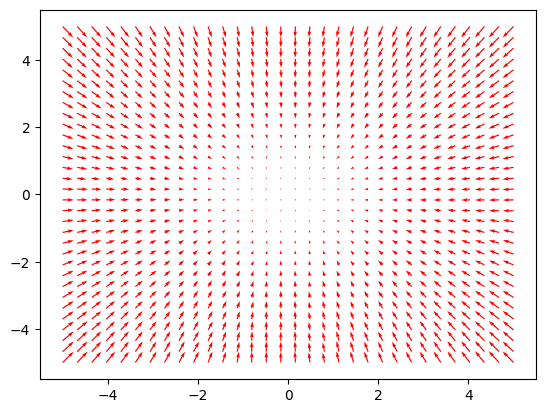

In [144]:
# generate the score field


X, Y = jnp.meshgrid(jnp.linspace(-5, 5, 32), jnp.linspace(-5, 5, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
plt.show()

In [145]:
#dimensions
# other distributions
# -mixtures of gaussians
# stochastic processes (brownian motion)

# - Orstein, Urlenbeck process
# diffrax - sample from a Orstein, Urlenbeck process
# Euler-Maruyama method


